내가 그리스도와 함께 십자가에 못 박혔나니 그런즉 이제는 내가 사는 것이 아니요 오직 내 안에 그리스도께서 사시는 것이라 이제 내가 육체 가운데 사는 것은 나를 사랑하사 나를 위하여 자기 자신을 버리신 하나님의 아들을 믿는 믿음 안에서 사는 것이라	(갈2:20)
<center><img src="https://github.com/idebtor/KMOOC-ML/blob/master/ipynb/images/MLwithPython.png?raw=true" width=1000></center>

__NOTE:__ The following materials have been compiled and adapted from the numerous sources including my own. Please help me to keep this tutorial up-to-date by reporting any issues or questions. Send any comments or criticisms to `idebtor@gmail.com` Your assistances and comments will be appreciated.

# 제 12-3 강: Gradient Descent 1 - Stochastic GD

## 학습목표 
- 배치 경사하강법(Batch GD)으로 학습의 정확도를 이해한다.
- 확률적 경사하강법(Stochastic GD)으로 학습의 효율성을 이해한다.


## 학습 내용
- MNIST 자료셋에 대한 다양한 경사하강법 비교하기
- 배치 경사하강법(Batch GD)의 정확도 이해하기 
- 확률적 경사하강법(Stochastic GD)으로 학습하기


In [2]:
import imp
import joy
imp.reload(joy)
import numpy as np

C:\Users\user\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 1. 기계학습 알고리즘 구현 

여러분은 신경망 학습에 관하여 충분한 지식을 갖추었고, 또한 앞 강의에서는 MNIST 데이터셋에 관한 사전 지식도 갖게 되었습니다. 이제는 신경망을 실제로 구현하는 일이 남았습니다. 

신경망 클래스를 만드는 코딩을 하기 전에 신경망 학습의 개략적 절차를 살펴보면 다음과 같이 4단계로 요약할 수 있습니다. 이러한 다음 4단계를 거치면서 신경망의 속성 중에 하나인 가중치가 훈련자료에 분별(인식, 분류, 적응)하도록 조정되는 과정을 __학습__한다고 합니다.   

(1) 기계학습에서 사용할 훈련자료와 테스트자료를 가져 온다.  
(2) 기계학습에 적절한 신경망(알고리즘)을 선택한다. 
(3) 훈련자료를 사용하여 신경망을 학습시킨다.  
(4) 테스트자료를 사용하여 신경망의 정확도(성능)을 점검한다. 

(3)단계 에서 말하고 있는 신경망을 학습하는 방법은 훈련자료의 손실함수 값을 줄이는 방법입니다.  훈련자료의 손실함수 값을 줄이기 위해 각 가중치의 기울기를 구합니다. 기울기는 손실함수의 값을 가장 작게하는 방향으로 움직이도록 합니다. 가중치 매개변수를 기울기 방향으로 조금씩(학습률) 갱신합니다.  (3)단계는 사용자가 미리 정한만큼 반복하거나 어떤 조건을 만족하게 되면 끝이 납니다.  이것이 신경망을 학습하는 방법입니다. 


## 2. 경사하강법

경사하강법은 세 가지 종류가 있습니다.  우리가 처음에 경험하였던 가장 기본적인 경사하강법인 배치 경사하강법이 있고, 다음은 확률적 경사하강법과 미니배치 경사하강법이 있습니다. 이에 대해 알아 보겠습니다. 

### 2.1 __(배치) 경사하강법__: <br>
경사하강법 혹은 배치 경사하강법라고 부르기도 하는 경사하강법 알고리즘은 훈련자료 전체를 사용해 손실(오차)를 계산한 후, 손실함수 $J(w)$의 경사를 따라 가장 가파른 하강 경로를 따라 내려가면서 매개변수 $w_j$를 갱신함으로 손실을 줄이는 방법입니다. 아래와 같은 수식이 생각이 나는지요? 여기서 m은 입력(훈련)자료의 수입니다. 

\begin{align}
  w_j &:= w_j - \eta \frac{\partial{J(w)}}{\partial{w_j}} \\
       &:= w_j + \eta\sum_i^m \big(y^{(i)} - h(z^{(i)}) \big) x_j^{(i)} \tag{1}
\end{align}

이것이 MNIST 데이터셋처럼 6 만개일 경우, 6만개의 모든 자료에 대한 오차(손실)을 모두 계산한 후, 가중치를 갱신하는 것이 배치(모든 자료가 한 묶음) 경사하강법입니다. 물론, 이 계산이 한 구문으로 다음과 같이 이루어질지라도 많은 계산은 피할 수 없습니다. 

`dW = dW - eta * np.dot(X.T, yhat - y)`

이 계산을 가능한 피해보려고 나온 알고리즘이 확률적 경사하강법입니다.  또한, 단순한 2차, 3차 손실함수의 곡면이나 곡선에서는 잘 작동하지만, 대부분의 다차원적인 손실함수의 곡면은 훨씬 더 복잡할 것입니다. 단순한 매개변수로만 움직이는 고차원 공간에서 안장점이나 지역최소값에 갇히는 경우가 있습니다. 특히 학습률이 낮은 경우에 더 발생할 수도 있습니다. 이러한 문제점을 해결하는데 도움이 되기도 하는 알고리즘이 확률적 경사하강법입니다. 


### 2.2 __확률적 경사하강법__: <br>

이 강의에서 다루는 확률적 경사하강법$^{stochastic \ gradient \ descent}$은 훈련자료를 하나씩 사용할 때마다 손실을 계산하여  매개변수들을 갱신하며 신경망을 학습합니다. 배치 경사하강법으로 구현한 XorNet처럼, 모든 훈련자료를 한번에 처리하여 손실을 계산하여 가중치를 조정하면서, 신경망 학습을 반복할 수 있습니다.  이러한 알고릐즘은 우리가 다루려고 하는 MNIST 데이터셋과 같이 상대적으로 많은 자료를 다룰 때는 비효율적입니다. 또한, 우리 일반인이 사용하는 범용 컴퓨터에서는 메모리가 문제가 되기도 합니다. 훈련자료가 이미 무작위로 입력되고 있다고 가정하기에 확률적이란 말이 붙은 것이라 간주합니다. 

\begin{align}
  w_j &:= w_j - \eta \frac{\partial{J(w)}}{\partial{w_j}} \\
       &:= w_j + \eta \big(y^{(i)} - h(z^{(i)}) \big) x_j^{(i)} \tag{2}
\end{align}

식(2)는 식(1)과 달리 $\sum_i^m$이 없다는 것이다. 왜냐하면, $m = 1$이기 때문이다. 


### 2.3 __미니배치 경사하강법__: <br>
반면에, 다음 강의에서는 경사하강법과 확률적 경사하강법의 장점들을 살리면서 빠르게 실행할 수 있는 미니배치 확률적 경사하강법$^{m \ gradient \ descent}$ 혹은 단순히 미니배치 경사하강법을 구현하는 방법을 설명할 것입니다.  미니배치는 무작위를 선택한 몇 개의 자료를 하나로 묶는 것을 말합니다.  무작위로 자료를 선정하기 때문에 '확률적'$^{stochastic}$이란 말이 나왔습니다.  예를 들면, 미니 배치를 16개로 설정하고 600번을 반복하면, 확률적으로 6만개의 이미지 자료들로 신경망을 학습했다고 볼 수 있다는 것입니다. 이러한 신경망 학습 방법을 미니배치 (확률적) 경사하강법이라고 부릅니다.  

## 3. MnistSGD 클래스 코드와 실행

MNIST 데이터셋의 자료를 다룰 수 있는 여러 방법에 대해 알아 보았습니다. 이제 이러한 사전 지식을 바탕으로 MNIST 데이터셋을 분류하는 신경망을 구현한 코드 즉 MnistSGD 클래스를 설명하려고 합니다. MnistSGD 클래스의 구현을 설명하기 앞서 전체적인 흐름을 파악하기 위해, MnistSGD 클래스를 사용하는 코드를 먼저 실행해 보는 것이 좋겠습니다.  

다음 셀을 실행하십시오. 다음 셀을 실행할 경우, 컴퓨터 성능에 따라 몇 분이 걸릴 수 있습니다. 결과는 다음과 같이 출력되어야 합니다.  MNIST 데이터셋이 data 폴더에 없어서 다운로드 해야 한다면, 시간이 약간 지체될 수도 있습니다. 
`
Training epoch 1/1.
MNIST classification accuracy 94.76%
`

In [2]:
import joy
(X, y), (Xtest, ytest) = joy.load_mnist()    # reading mnist dataset

n_x, n_h, n_y = 784, 100, 10                # setting hyperparameters
nn = joy.MnistSGD(n_x, n_h, n_y, epochs=5)  # Instantiating a MnistNet class object
nn.fit(X, y)                                # training nn MnistNet objcet with X, y
accuracy = nn.evaluate(Xtest, ytest)      
print('MNIST accuracy {}%'.format(accuracy))
# MNIST classification accuracy 94.76% with epochs = 2
# MNIST classification accuracy 95.64% with epochs = 2
# MNIST classification accuracy 96.13% with epochs = 3
# MNIST classification accuracy 96.04% with epochs = 4

Training epoch 1/5.
A0.shape=(784, 1), Y0.shape=(10, 1)
Z1.shape=(100, 1), A1.shape=(100, 1), Z2.shape=(10, 1), A2.shape=(10, 1)
E1.shape=(100, 1), E2.shape=(10, 1), dZ1.shape=(100, 1), dZ2.shape=(10, 1)
Training epoch 2/5.
A0.shape=(784, 1), Y0.shape=(10, 1)
Z1.shape=(100, 1), A1.shape=(100, 1), Z2.shape=(10, 1), A2.shape=(10, 1)
E1.shape=(100, 1), E2.shape=(10, 1), dZ1.shape=(100, 1), dZ2.shape=(10, 1)
Training epoch 3/5.
A0.shape=(784, 1), Y0.shape=(10, 1)
Z1.shape=(100, 1), A1.shape=(100, 1), Z2.shape=(10, 1), A2.shape=(10, 1)
E1.shape=(100, 1), E2.shape=(10, 1), dZ1.shape=(100, 1), dZ2.shape=(10, 1)
Training epoch 4/5.
A0.shape=(784, 1), Y0.shape=(10, 1)
Z1.shape=(100, 1), A1.shape=(100, 1), Z2.shape=(10, 1), A2.shape=(10, 1)
E1.shape=(100, 1), E2.shape=(10, 1), dZ1.shape=(100, 1), dZ2.shape=(10, 1)
Training epoch 5/5.
A0.shape=(784, 1), Y0.shape=(10, 1)
Z1.shape=(100, 1), A1.shape=(100, 1), Z2.shape=(10, 1), A2.shape=(10, 1)
E1.shape=(100, 1), E2.shape=(10, 1), dZ1.shape=(100, 1)

__JoyQuiz__: 위에서 사용한 신경망의 W1의 형상을 어떻게 알아볼 수 있을까요? <br>
(1) W1.shape <br>
(2) nn.W1.shape  <br>
(3) MnistNet.W1.shape <br>
(4) joy.MnistNet.W1.shape <br>
__JoyAnswer__: (2)

__JoyQuiz__: 위에서 사용한 신경망의 W2의 형상은 무엇입니까? <br>
(1) (100, 784) <br>
(2) (784, 100)  <br>
(3) (10, 100) <br>
(4) (100, 10) <br>
__JoyAnswer__: (3)

## 3. MnistSGD클래스 신경망의 4단계 학습

MnistSGD 클래스는 다음과 같이 4 단계로 작업하고 있는 것을 관찰할 수 있습니다. 

1. `load_mnist()`함수는 data 폴더에 있는 MNIST 데이터셋에서 (훈련 이미지, 훈련 레이블), (테스트 이미지, 테스트 레이블)로 구분하여 반환합니다.  만약 data 폴더에 자료가 존재하지 않으면, MNIST 공식사이트에서 자료를 다운로드합니다.  그러므로, 처음에는 시간이 걸리지만 그 이후로에는 여러분 컴퓨터에 있는 자료를 읽어 오므로 시간이 걸리지 않습니다. 특히, 두 번째 이후로는 pickle의 기능을 사용하여 상당히 빠르게 자료를 접근할 수 있습니다. 

2. MNIST 데이터셋을 다루기 위한 신경망을 앞 장에서 설계한대로 노드(뉴론)의 수를 설정하고 객체를 생성하기 위하여 MnistNet()를 호출합니다. n_x와 n_y는 입력 자료의 특성에 따라 정해진 값이므로, 변경할 수 없지만, 은닉층의 노드 수는 "적당한" 값으로 정하면 됩니다.  어떤 값이 적당한 값인지는 경험칙에 따르면 됩니다. 
    - n_x -- 입력 노드의 수
    - n_h -- 은닉층 노드의 수
    - n_y -- 출력층 노드의 수 <br>
    
    정해진 파라미터로 MnistNet()호출하여 신경망 객체를 생성합니다. 이 객체는 이 신경망의 다양한 정보, 예를 들면, 가중치, 학습률, 뉴론의 수, epoch단계별 비용 등등을 저장하고 있습니다. 
    
3. `fit()` 메소드는 신경망 훈련에 사용할 훈련 이미지와 훈련 레이블을 받아서 최종적으로 가중치 결정합니다. 
    
4. `evaluate()` 메소드는 훈련에 전혀 사용하지 않은 테스트 이미지로 신경망이 얼마나 잘 분류하는지 평가합니다.   `evaluate()` 메소드는 `predict()` 메소드를 호출하여 분류를 하고, 그의 반환값을 레이블과 비교하여 정확도를 계산합니다. 

## 4. MnistSGD 클래스 코드 분석

MnistSGD 클래스의 코드를 분석하기 전에, MnistSGD.py 코드 전체를 한번 훝어 보는 것이 도움이 될 것입니다. 다음 셀의 첫글자를 삭제하고 실행하면 MnistNet 클래스의 소스코드를 볼 수 있습니다. joy 모듈에 있는 코드와 약간 차이가 있을 수 있습니다. 

In [3]:
# %load code/MnistSGD.py

Overwriting code/MnistSGD.py


In [3]:
import joy

(X, y), (Xtest, ytest) = joy.load_mnist()    # reading mnist dataset
nn = joy.MnistSGD(784, 100, 10, eta = 0.2, epochs=5)   # Instantiating a class object
nn.fit(X, y)                                     # training nn MnistNet objcet with X, y
accuracy = nn.evaluate(Xtest, ytest)      
print('MNIST classification accuracy {}%'.format(accuracy))
# n_h = 100
# MNIST classification accuracy 94.76% with epochs = 2, eta = 0.1
# MNIST classification accuracy 95.64% with epochs = 2
# MNIST classification accuracy 96.13% with epochs = 3
# MNIST classification accuracy 96.04% with epochs = 4
# MNIST classification accuracy 94.45% with epochs = 20 eta = 0.2  overfitting

Training epoch 1/5.
A0.shape=(784, 1), Y0.shape=(10, 1)
Z1.shape=(100, 1), A1.shape=(100, 1), Z2.shape=(10, 1), A2.shape=(10, 1)
E1.shape=(100, 1), E2.shape=(10, 1), dZ1.shape=(100, 1), dZ2.shape=(10, 1)
Training epoch 2/5.
A0.shape=(784, 1), Y0.shape=(10, 1)
Z1.shape=(100, 1), A1.shape=(100, 1), Z2.shape=(10, 1), A2.shape=(10, 1)
E1.shape=(100, 1), E2.shape=(10, 1), dZ1.shape=(100, 1), dZ2.shape=(10, 1)
Training epoch 3/5.
A0.shape=(784, 1), Y0.shape=(10, 1)
Z1.shape=(100, 1), A1.shape=(100, 1), Z2.shape=(10, 1), A2.shape=(10, 1)
E1.shape=(100, 1), E2.shape=(10, 1), dZ1.shape=(100, 1), dZ2.shape=(10, 1)
Training epoch 4/5.
A0.shape=(784, 1), Y0.shape=(10, 1)
Z1.shape=(100, 1), A1.shape=(100, 1), Z2.shape=(10, 1), A2.shape=(10, 1)
E1.shape=(100, 1), E2.shape=(10, 1), dZ1.shape=(100, 1), dZ2.shape=(10, 1)
Training epoch 5/5.
A0.shape=(784, 1), Y0.shape=(10, 1)
Z1.shape=(100, 1), A1.shape=(100, 1), Z2.shape=(10, 1), A2.shape=(10, 1)
E1.shape=(100, 1), E2.shape=(10, 1), dZ1.shape=(100, 1)

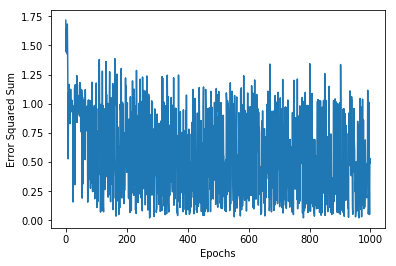

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt 

plt.plot(range(len(nn.cost_[:1000])), nn.cost_[:1000])
plt.xlabel('Epochs')
plt.ylabel('Sum of Squared Error')
plt.show()

MnistSGD 클래스는 다음과 같은 메소드들로 구성되어 있습니다. 

```
- def __init__(self, n_x, n_h, n_y, eta = 0.1, epochs = 1, random_seed=1):
- def forpass(self, A0):
- def fit(self, X, y):
- def predict(self, X):
- def g(self, x):  
- def g_prime(self, x): 
- def evaluate(self, Xtest, ytest): 
- def evaluate_onebyone(self, Xtest, ytest):
```

- `def __init__(self, n_x, n_h, n_y, eta = 0.1, epochs = 1, random_seed=1):` <br> 
`MnistSGD` 클래스를 생성할 때 불려지는 메소드입니다. 하이퍼 파라미터를 초기 설정할 때 사용합니다.  각 층의 노드의 수외에 학습률과 반복횟수와 난수 발생 씨드값을설정합니다. 또한 `n_x, n_h, n_y` 값으로 가중치를 `W1, W2`를 초기화합니다. 가중치 `W1, W2`는 객체의 속성으로 저장됩니다. <br>

- `def forpass(self, A0):` <br>
입력 자료 `A0`를 받아 순전파 계산을 합니다.  순전파의 결과로 `Z1, A1` 즉 은닉층의 입력과 출력, `Z2, A2` 출력층의 입력과 출력을 반환합니다.  이 메소드는 `fit(), predict()`메소드에서 호출합니다. 

- `def fit(self, X, y):` <br>
학습을 위한 훈련자료를 받아 순전파와 역전파 계산을 합니다.  반복적으로 경사하강법을 적용하여 가중치를 조정합니다. 최종 결과로 가중치 `W1, W2`가 객체의 속성으로 저장됩니다. <br>

출력층 10개의 노드와 오차를 계산하기 위하여 레이블 `y`를 `hot_one_encoding()`으로 전환합니다.  이 부분은 XorNet와 다른 부분입니다.  

- `def predict(self, X):` <br>
테스트 자료를 받아 신경망이 예측하는 결과(y hat)를 반환합니다.  이미 학습을 통해 구한 신경망의 가중치를 활용하여 계산합니다. `forpass()` 메소드를 사용합니다. <br>

- `def evaluate(self, Xtest, ytest):` <br>
테스트 이미지, 레이블 자료를 받아 `predict()`를 호출하여 신경망의 예측 값(y hat)을 받고, 레이블(y)과 비교하여 정확도 즉 신경망의 성능을 계산합니다. 

`MnistSGD` 클래스의 핵심 알고리즘 코드는 `XorNet`와 거의 동일하지만, `fit()`과 `evaluate()` 메소드에서 자료를 다루는 방법이 다르기 때문에 이에 대한 이해가 필요합니다.  

## 5. MnistSGD fit() 메소드

다음 그림1은 `MnistSGD`클래스의 입출력 자료의 형상과 변수 , `fit()` 메소드가 호출하는 `feedpass()`메소드 부분의 연산을 보여주고 있습니다. 

<center><img src="https://github.com/idebtor/KMOOC-ML/blob/master/ipynb/images/ch11/MnistSGDOutline.PNG?raw=true" width="600">
<center>그림 1: MnistSGD 확률적 경사하강법 구현(m = 1, examples = 60000)</center>

```
def fit(self, X, y):
    self.cost_ = []
    m_samples = len(y)
    Y = joy.one_hot_encoding(y, self.n_y)       # (m, n_y) = (m, 10)   one-hot encoding
    for epoch in range(self.epochs):          
        for m in range(m_samples):            
            A0 = np.array(X[m], ndmin=2).T      # A0 : inputs, minimum 2 dimensional array
            Y0 = np.array(Y[m], ndmin=2).T      # Y: targets

            Z1, A1, Z2, A2 = self.forpass(A0)          # forward pass
            E2 = Y0 - A2                       # E2: output errors
            E1 = np.dot(self.W2.T, E2)         # E1: hidden errors
            # back prop, error prop
            dZ2 = E2 * self.g_prime(Z2)        # backprop      # dZ2 = E2 * A2 * (1 - A2)  
            dZ1 = E1 * self.g_prime(Z1)        # backprop      # dZ1 = E1 * A1 * (1 - A1)  
            # update weights
            self.W2 +=  self.eta * np.dot(dZ2, A1.T)      # update output layer weights
            self.W1 +=  self.eta * np.dot(dZ1, A0.T)      # update hidden layer weights
            self.cost_.append(np.sqrt(np.sum(E2 * E2)))
    return self
```

학습을 위한 훈련자료를 받아 순전파와 역전파 계산을 합니다.  반복적으로 경사하강법을 적용하여 가중치를 조정합니다. 최종 결과로 가중치 `W1, W2`가 객체의 속성으로 저장됩니다. <br>

- `self.cost_ = []` <br>
학습을 할 때마다 발생하는 손실을 저장하였다가 분석하거나 시각화에 사용합니다. 

- `Y = joy.one_hot_encoding(y, self.n_y)` <br>
XorNet와 한 가지 다른 점은 원-핫 인코등을 사용한다는 점입니다. 

이는 앞 강의에서 설명했듯이 샘플 자료 하나에 대해 우리가 가지고 있는 레이블 y의 값도 하나입니다.  그러나, 출력층에서 신경망이 해야 할 일은 10개의 가능한 숫자 중에 하나를 결정해야 하므로, 출력 노드가 10개입니다. 출력층의 출력 yhat이 10개이므로 이와 비교 가능한 y도 값이 10개 이어야 합니다. 이를 위해 원-핫 인코딩을 합니다. 예를 들면, `[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]`처럼 정답(레이블)을 뜻하는 원소만 1이고 나머지는 모두 0인 배열입니다. 

- `for epoch in range(self.epochs):`  <br>
또한 모든 훈련이미지를 하나 하나를 신경망을 학습하는데 사용합니다. 60,000장의 모든 이미지를 학습에 사용하기 때문에 에폭의 수가 클 이유가 없습니다. 여기서, epochs = 1 디폴트인 이유입니다. 

__에폭$^{epoch}$__:  에폭은 일종의 단위입니다. 학습 과정에서 모든 훈련자료를 소진했을 때 1 에폭이라고 합니다. 때때로 우리가 무작위로 훈련자료를 선택하여 즉 미니 배치로 학습할 경우가 있습니다. 예를 1000개의 전체 훈련자료에서 20개를 미니 배치로 학습한다면, 500번의 반복적 학습을 한 경우를 1 에폭이라고 합니다. 

## 6. MnistSGD의 정확도(성능) 평가

신경망을 학습하고 난 이후, 신경망이 학습을 하면서 전혀 경험해보지 못한 자료들에 대해 얼마나 잘 예측(분류)를 하는지 정확도를 측정해볼 필요가 있습니다.  

이러한 과정은 어떻게 이루어지는지, 신경망의 학습을 위해서가 아니라 우리 자신이 학습하기 위해서 신경망의 정확도를 측정하는 두 종류의 메소드를 만들어 보았습니다. 하나는 메소드 이름이 말하듯이 one by one즉 테스트 자료를 하나씩 신경망에 보내어 바르게 예측하는지 테스트 해보는 것입니다.  이 방법은 나중에 어떤 자료가 잘못 분류되는 찾아내는데도 도움이 될 것입니다.  다른 하나는 테스트 자료를 한번에, 여기서는 MNIST 테스트 이미지 10,000개, 모두 처리하는 방법입니다. 

### 6.1 evaluate_onebyone(self, Xtest, ytest) 
```
def evaluate_onebyone(self, Xtest, ytest):
    m_samples = len(ytest)
    scores = 0
    for m in range(m_samples):
        A2 = self.predict(Xtest[m])
        yhat = np.argmax(A2)
        if yhat == ytest[m]:
            scores += 1
    return scores/m_samples * 100
```

- 테스트 이미지`(m, 768)`와 레이블 자료`(m, 1)`를 인자로 받습니다. `(m = 10000)`
- 자료가 몇 개인지 파악합니다. 
- `scores`변수를 초기화 합니다. 
- 각 자료$^{sample}$에 대해 `predict()`를 호출하여 출력 `A2` 즉 $\hat{y}$를 구합니다. 
- $\mathbf{\hat{y}}$은 원-핫 인코딩한 배열(10, 1)입니다. 배열의 원소들 가운데 최대값의 인덱스를 반환하는 함수 `argmax()`로 `yhat`을 구합니다. 
- `yhat`이 레이블 y와 같으면, scores를 증가합니다. 
- 모든 자료에 대한 예측이 끝나면,  scores에 대한 백분율을 반환합니다. 

### 6.2 evaluate(self, Xtest, ytest) 

```
def evaluate(self, Xtest, ytest):       # fully vectorized calculation
    m_samples = len(ytest)   
    A2 = self.predict(Xtest)
    yhat = np.argmax(A2, axis = 0)
    scores = np.sum(yhat == ytest)
    return scores/m_samples * 100
```

여기서 중요한 아이디어는 `predict()` 메소드가 입력자료를 인자로 받을 때 그 자료가 한 개이든지, 여러 개이든지 관계없디지 모두 한꺼번에 처리할 수 있도록 코딩이 되어 있다는 사실입니다. 이러한 파이썬의 기능을 이용하는 것을 벡터라이제이션$^{vectorization}$이라고 합니다. `predict()` 메소드 안에서도 `for loop`없이 처리합니다. 

- def evaluate(self, Xtest, ytest): <br>
테스트 이미지`(m, 768)`와 레이블 자료`(m,)`를 인자로 받습니다. `(m = 10000)`

- m_samples = len(ytest) <br>
  자료가 몇 개인지 파악합니다. 
  
- A2 = self.predict(Xtest) <br>
모든 테스트 자료 Xtest(m, 768)에 대해 `predict()`를 호출하여 출력 `A2` 즉 $\hat{y}$를 구합니다. `predict()`는 `(10, m)`형상의 결과를 반환합니다. 

- yhat = np.argmax(A2, axis = 0) <br>
$\mathbf{\hat{y}}$은 원-핫 인코딩한 배열`(10, m)`입니다. 배열의 원소들 가운데 최대값의 인덱스를 반환하는 함수 `argmax()`로 `yhat`을 구합니다.  `argmax()`에 `axis=0` 인자를 추가한 것은 배열에서 첫번째`(0 axis)`의 차원을 구성하는 각 원소에서 최대값의 인덱스를 찾으라는 것입니다. `A2`의 형상은 `(10, m)`이므로, 10개 원소들에서 최대 인덱스를 찾는 것입니다. 그러므로, 결과는 `(m,)`의 형상을 `yhat`을 구할 수 있습니다. 이 형상은 `ytest`의 것과 일치합니다. 

- scores = np.sum(yhat == ytest) <br>
`yhat`과 `ytest`는 형상이 모두 `(m,)`입니다. 그러므로, 두 원소를 비교하여 서로 같은 것은 `True`가 되면, 그 `True`의 원소 갯수를 모두 더한 값입니다.  이 `yhat`과 `ytest`를 분석하면 어떠한 숫자가 어떠한 숫자로 잘못 예측하였는지 찾아낼 수 있습니다. 

- return scores/m_samples * 100
- 모든 자료에 대한 예측이 끝나면,  `scores`에 대한 백분율을 반환합니다. 

이와 같이 넘파이 행렬의 특성을 살려서 연산하는 것을 벡터라이제이션이라고 하며, GPU같은 프로세서가 벡터라이제이션을 지원하여 연산을 더욱 빠르게 할 수 있습니다. 

### 6.3 오차(self.cost_)의 시각화 

신경망을 학습시키면서 발생하는 오차(손실)를 MnistSGD객체의 `cost_` 에 저장되어 있습니다. 이를 시각화해서 신경망이 어떻게 학습을 하였는지, 손실을 최소화하는 방향을 수렴하였는지 분석할 수 있습니다.  다음 셀의 코드를 실행해 봅시다.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt 

plt.plot(range(len(nn.cost_)), nn.cost_)
plt.xlabel('Epochs')
plt.ylabel('Squared Sum Error')
plt.show()

모든 훈련자료마다 계산된 제곱 오차이므로 MNIST 훈련이미지 자료의 경우, 60000개의 손실이 측정이 된 것입니다. 각각의 자료를 훈련하였으므로, 거의 모든 과정에서 오차가 등락이 심한 것을 볼 수 있습니다. 아래 그림과 같이 60000개의 손실값 중에서 앞부분 1000개의 자료만 볼지라도 크게 다르지 않습니다.  왜냐하면, 각각 훈련자료마다 하나씩 훈련하고 그 오차를 기록하는 확률적 경사하강법으로 학습을 진행했기 때문입니다.  

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt 

plt.plot(range(len(nn.cost_[:500])), nn.cost_[:500])
plt.xlabel('Epochs')
plt.ylabel('Squared Sum Error')
plt.show()

## 학습률과 학습률 스케줄

설명 추가 할 것


In [4]:
#%%writefile code/MnistSGD_LS.py
#%load code/MnistSGD_LS.py
class MnistSGD(object):
    def __init__(self, n_x, n_h, n_y, eta = 0.1, epochs = 1, random_seed=1):
        self.n_x = n_x
        self.n_h = n_h
        self.n_y = n_y
        self.eta = eta
        self.epochs = epochs
        np.random.seed(random_seed)
        self.W1 = 2*np.random.random((self.n_h, self.n_x)) - 1  # between -1 and 1
        self.W2 = 2*np.random.random((self.n_y, self.n_h)) - 1  # between -1 and 1
        #print('W1.shape={}, W2.shape={}'.format(self.W1.shape, self.W2.shape))
        
    def forpass(self, A0):
        Z1 = np.dot(self.W1, A0)          # hidden layer inputs
        A1 = self.g(Z1)                   # hidden layer outputs/activation func
        Z2 = np.dot(self.W2, A1)          # output layer inputs
        A2 = self.g(Z2)                   # output layer outputs/activation func
        return Z1, A1, Z2, A2

    def fit(self, X, y): 
        self.cost_ = []
        self.m_samples = len(y)
        Y = joy.one_hot_encoding(y, self.n_y)       # (m, n_y) = (m, 10)   one-hot encoding
        
        # learning rate is scheduled to decrement by a step of which the inteveral from 0 to eta
        # eqaully divided by total number of iterations (or epochs * m_samples)
        # eta_scheduled = np.linspace(self.eta, 0.0001, m_samples * self.epochs)
        
        for epoch in range(self.epochs):
            print('Training epoch {}/{}'.format(epoch+1, self.epochs))
            
            for m in range(self.m_samples):            
                # input X can be tuple, list, or ndarray
                # random_index = np.random.randint(m_samples)
                A0 = np.array(X[m], ndmin=2).T     # A0 : inputs, minimum 2 dimensional array
                Y0 = np.array(Y[m], ndmin=2).T    # Y: targets

                Z1, A1, Z2, A2 = self.forpass(A0)          # forward pass

                E2 = Y0 - A2                       # E2: output errors
                E1 = np.dot(self.W2.T, E2)         # E1: hidden errors

                # back prop, error prop
                dZ2 = E2 * self.g_prime(Z2)       
                dZ1 = E1 * self.g_prime(Z1)     

                # update weights
                # eta = eta_scheduled[epoch * m_samples + m]
                self.W2 +=  self.eta * np.dot(dZ2, A1.T)     
                self.W1 +=  self.eta * np.dot(dZ1, A0.T)    
                
                self.cost_.append(np.sqrt(np.sum(E2 * E2)))
        return self

    def predict(self, X):
        A0 = np.array(X, ndmin=2).T         # A0: inputs
        Z1, A1, Z2, A2 = self.forpass(A0)   # forpass
        return A2                                       

    def g(self, x):                 # activation_function: sigmoid
        x = np.clip(x, -500, 500)   # prevent from overflow, 
        return 1.0/(1.0+np.exp(-x)) # stackoverflow.com/questions/23128401/
                                    # overflow-error-in-neural-networks-implementation
    
    def g_prime(self, x):                    # activation_function: sigmoid derivative
        return self.g(x) * (1 - self.g(x))
    
    def evaluate(self, Xtest, ytest):       # fully vectorized calculation
        m_samples = len(ytest)  
        A2 = self.predict(Xtest)
        yhat = np.argmax(A2, axis = 0)
        scores = np.sum(yhat == ytest)
        return scores/m_samples * 100
        
    def evaluate_onebyone(self, Xtest, ytest):
        m_samples = len(ytest)
        scores = 0
        for m in range(m_samples):
            A2 = self.predict(Xtest[m])
            yhat = np.argmax(A2)
            if yhat == ytest[m]:
                scores += 1
        return scores/m_samples * 100

In [9]:
import joy

(X, y), (Xtest, ytest) = joy.load_mnist()   
nn = MnistSGD(784, 100, 10 , eta = 0.1, epochs=4)         
nn.fit(X, y)     
self = nn.evaluate(X, y) 
test = nn.evaluate(Xtest, ytest)      
print('epochs:{}, accuracy self:{}, test:{}%'.
      format(nn.epochs, np.round(self,3), test))
#Can you believe this output? 
#Training epoch 1/4
#Training epoch 2/4
#Training epoch 3/4
#Training epoch 4/4
#epochs:4, accuracy self:97.235, test:96.04%

Training epoch 1/4
Training epoch 2/4
Training epoch 3/4
Training epoch 4/4
epochs:4, accuracy self:97.235, test:96.04%


'Is this true? \nTraining epoch 1/4\nTraining epoch 2/4\nTraining epoch 3/4\nTraining epoch 4/4\nepochs:4, accuracy self:97.235, test:96.04%\n'

In [10]:
import joy
(X, y), (Xtest, ytest) = joy.load_mnist()   
nn = MnistSGD(784, 100, 10 , eta = 0.1, epochs=20)         
nn.fit(X[:1000], y[:1000])                

accuracy = nn.evaluate(Xtest[:100], ytest[:100])      
self = nn.evaluate(X, y) 
test = nn.evaluate(Xtest, ytest)      
print('epochs:{}, accuracy self:{}, test:{}%'.
      format(nn.epochs, np.round(self,3), np.round(test,3)))

Training epoch 1/20
Training epoch 2/20
Training epoch 3/20
Training epoch 4/20
Training epoch 5/20
Training epoch 6/20
Training epoch 7/20
Training epoch 8/20
Training epoch 9/20
Training epoch 10/20
Training epoch 11/20
Training epoch 12/20
Training epoch 13/20
Training epoch 14/20
Training epoch 15/20
Training epoch 16/20
Training epoch 17/20
Training epoch 18/20
Training epoch 19/20
Training epoch 20/20
epochs:20, accuracy self:86.027, test:86.05%


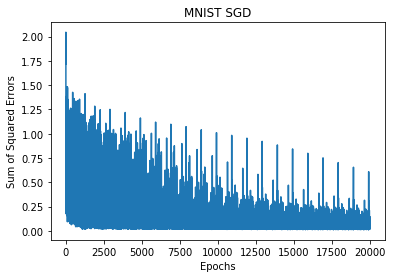

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt 

plt.plot(range(len(nn.cost_)), nn.cost_)
plt.xlabel('Epochs')
plt.ylabel('Sum of Squared Errors')
plt.title('MNIST SGD')
plt.show()

## 새로운 학습자료 만들기 - 회전

다음은 입력자료에서 한 자료만 선택하여 보여준 후, 동일한 자료를 시계방향으로 10도 회전한 자료를 만들어 보여주는 코드입니다. 

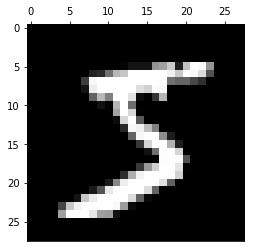

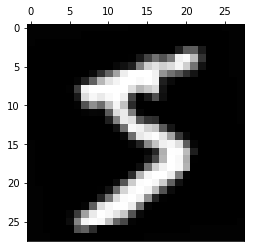

In [3]:
import numpy as np
import scipy.ndimage
%matplotlib inline
import matplotlib.pyplot as plt 

(X, y), (Xtest, ytest) = joy.load_mnist()    # reading mnist dataset
Xr = X[0].reshape(28, 28)
joy.show_mnist(Xr)
Xr = scipy.ndimage.rotate(Xr, 10.0, cval=0.01, order=1, reshape=False)
joy.show_mnist(Xr)

다음은 위와 같은 훈련자료를 회전하되 다섯개의 자료를 한번에 다루는 코드이며, 한번은 시계 방향으로 12도 회전하고, 그 다음은 반시계 방향으로 12도 회전하는 코드입니다. 

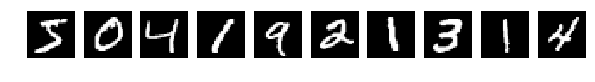

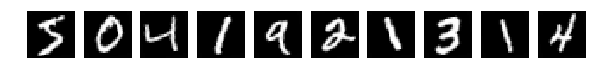

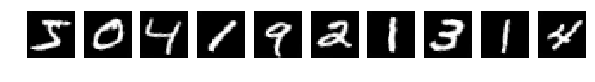

In [10]:
(X, y), (Xtest, ytest) = joy.load_mnist()    # reading mnist dataset
Xo = X[:10].reshape(-1, 28, 28)
joy.show_mnist_grid(Xo)
Xcw = scipy.ndimage.rotate(Xo, 12, axes = (2, 1), cval=0.01, order=1, reshape=False)
joy.show_mnist_grid(Xcw)
Xcc = scipy.ndimage.rotate(Xo, -12.0, axes = (2, 1), cval=0.01, order=1, reshape=False)
joy.show_mnist_grid(Xcc)

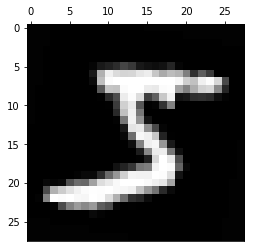

In [8]:
joy.show_mnist(Xcc[0])

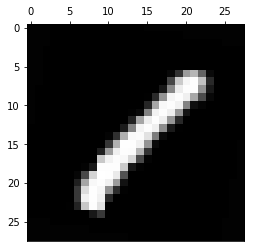

In [13]:
joy.show_mnist(Xcc[3])

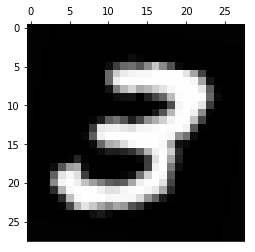

In [14]:
joy.show_mnist(Xcc[7])

지금까지의 코드를 활용하여 MNIST 데이터셋의 자료를 회전하는 함수입니다.  현재 다루고자 하는 학습자료를 손쉽게 회전하여, 기존의 학습자료에 추가할 수 있도록 돕는 함수입니다. 

In [ ]:
import scipy.ndimage
def append_mnist_rotation(X, y, n_images, degree):
    """ X -- images, shape(m, 784), m is the number of images 
        y -- labels, shape(m, )
        n_images -- number of images randomly selected to rotate
        degree -- rotation angle
        
        Returns:
        X -- images, shape(m + n_images, 784), randomly selected 
              n_images rotated and appended to the end of X
        y -- labels, shape(m + n_images, ) 
              labels appended according to rotated images 
              
        Author: idebtor@gmail.com
        2018/05/01 - Created
    """
    X = X.reshape(-1, 28, 28)
    selected = np.random.choice(X.shape[0], n_images)
    Xr = X[selected]
    yr = y[selected]
    Xr = scipy.ndimage.rotate(Xr, 15.0, axes=(2, 1), cval=0.01, order=1, reshape=False)
    X = np.concatenate((X, Xr), axis = 0)
    y = np.concatenate((y, yr), axis = 0)
    return X.reshape(-1, 784), y

아래 셀은 append_mnist_rotation()함수를 테스트하고, 사용법을 보여줍니다. 

In [ ]:
(X, y), (Xtest, ytest) = joy.load_mnist()    # reading mnist dataset
Xo = X[:20].reshape(-1, 28, 28)
yo = y[:20]
show_mnist_grid(Xo.reshape(-1, 28, 28))

Xr, yr = append_mnist_rotation(Xo, yo, 5, 15)
show_mnist_grid(Xr.reshape(-1, 28, 28))
print(yr)

기존의 MNIST 데이터셋의 훈련자료에 시계방향/반시계방향으로 회전한 이미지를 각각 10,000장씩 추가하여 MnistSGD를 실행하는 예제입니다. 

In [ ]:
import joy

(X, y), (Xtest, ytest) = joy.load_mnist()    # reading mnist dataset
print(X.shape, y.shape)
print('adding rotated by 10 degree images...')
X, y = mnist_rotation_added(X, y, 10000, 10)  # 
print('adding rotated by -10 degree images...')
X, y = mnist_rotation_added(X, y, 10000, -10) 
print(X.shape, y.shape)

nn_one = MnistSGD(784, 150, 10, eta=0.2)     
nn_one.fit(X, y)            

accuracy = nn_one.evaluate(Xtest, ytest)      
print('MNIST accuracy {}%'.format(accuracy))

#### 참고자료
- [Neural Networks and Deep Learnings](http://neuralnetworksanddeeplearning.com/) by  Michael Nielsen : 

- [A Gentle Introduction to Mini-Batch Gradient Descent](https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/) by Jason Brownlee


## 학습 정리
- 배치 경사하강법(Batch GD)으로 학습의 정확도를  이해하기
- 확률적 경사하강법(Stochastic GD)으로 학습의 효율성을 이해하기 


----------
_For God so loved the world that he gave his one and only Son, that whoever believes in him shall not perish but have eternal life. John3:16_